# Comparativa de modelos y búsqueda del mejor.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    GradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    plot_tree
)
from xgboost import XGBClassifier, XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from scipy.sparse import csr_matrix, hstack

## Carga de datos.

In [2]:
PATH_DIRECTORIO_DATOS_PROCESSED = "../../data/processed"
df = pd.read_csv(f"{PATH_DIRECTORIO_DATOS_PROCESSED}/data_processed.csv", index_col = 0)

In [3]:
# Seleccionamos las columnas independientes
list_columnas_independientes = df.drop(columns='is_canceled').columns.to_list()
list_columnas_independientes

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'has_company']

In [4]:
# Preparación de los datos.
X = df[list_columnas_independientes]
y = df['is_canceled']

In [11]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

In [14]:
scaler = StandardScaler()
X_scaled_num = scaler.fit_transform(X[num_cols])

In [15]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_scaled_cat = encoder.fit_transform(X[cat_cols])

In [ ]:
X_scaled_num = csr_matrix(X_scaled_num)

In [28]:
X = hstack([X_scaled_num, X_scaled_cat])

In [29]:
# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regresión logísitica.

In [30]:
# Entrenamos el modelo de Regresión logística usando GridSearchCV para encontrar los mejores hiperparámetros
dict_parametros = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

model_rl = LogisticRegression(max_iter=1000, random_state=42)
model_rl_cv = GridSearchCV(model_rl, dict_parametros, cv=5, scoring='accuracy')
model_rl_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
             scoring='accuracy')

In [31]:
# Mostramos los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros encontrados: {model_rl_cv.best_params_}")
print(f"Mejor score obtenido: {model_rl_cv.best_score_:.2%}")

Mejores hiperparámetros encontrados: {'C': 10, 'solver': 'liblinear'}
Mejor score obtenido: 83.07%


In [32]:
best_model_rl = model_rl_cv.best_estimator_

In [33]:
# Hacemos predicciones sobre el conjunto de test
y_pred = best_model_rl.predict(X_test)

In [34]:
# Obtenemos las probabilidades de pertenencia a la clase positiva (1)
y_proba = best_model_rl.predict_proba(X_test)[:, 1]

In [35]:
# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2%}")
print(f"Precisión: {prec:.2%}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  83.46%
Precisión: 82.05%
Recall:    0.72
F1-Score:  0.76
AUC:       0.92



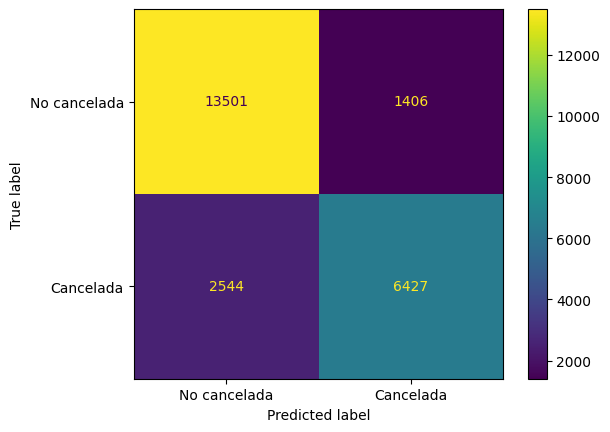

In [38]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No cancelada', 'Cancelada'])
disp.plot()
plt.show()